In [1]:
import csv
import time
from pathlib import Path

import click
import numpy as np
import torch
from tqdm import tqdm

from diffdrr import DRR, load_example_ct
from diffdrr.metrics import XCorr2
from diffdrr.visualization import plot_drr

In [2]:
def get_true_drr():
    volume, spacing = load_example_ct()
    bx, by, bz = torch.tensor(volume.shape) * torch.tensor(spacing) / 2
    true_params = {
        "sdr": 200.0,
        "theta": torch.pi,
        "phi": 0,
        "gamma": torch.pi / 2,
        "bx": bx,
        "by": by,
        "bz": bz,
    }
    return volume, spacing, true_params


def get_initial_parameters(true_params):
    sdr = true_params["sdr"]
    theta = true_params["theta"] + np.random.uniform(-np.pi / 4, np.pi / 4)
    phi = true_params["phi"] + np.random.uniform(-np.pi / 3, np.pi / 3)
    gamma = true_params["gamma"] + np.random.uniform(-np.pi / 3, np.pi / 3)
    bx = true_params["bx"] + np.random.uniform(-30.0, 31.0)
    by = true_params["by"] + np.random.uniform(-30.0, 31.0)
    bz = true_params["bz"] + np.random.uniform(-30.0, 31.0)
    return sdr, theta, phi, gamma, bx, by, bz

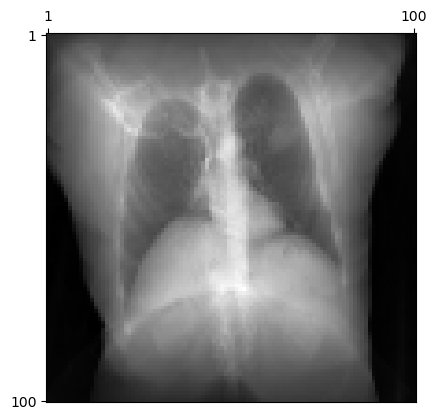

In [3]:
# Get the ground truth DRR
volume, spacing, true_params = get_true_drr()
drr = DRR(volume, spacing, height=100, delx=10.0, device="cuda")
ground_truth = drr(**true_params)
plot_drr(ground_truth)

In [4]:
drr

Parameter containing:
tensor([200.], device='cuda:0')
Parameter containing:
tensor([[3.1416, 0.0000, 1.5708]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[180.0000, 180.0000, 166.2500]], device='cuda:0', requires_grad=True)

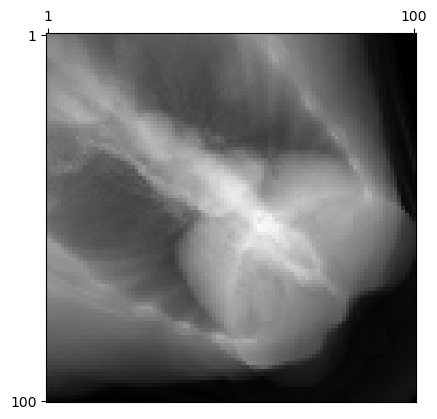

In [5]:
# Initialize the DRR and optimization parameters
sdr, theta, phi, gamma, bx, by, bz = get_initial_parameters(true_params)
estimate = drr(sdr, theta, phi, gamma, bx, by, bz)  # Initialize the DRR generator
criterion = XCorr2(zero_mean_normalized=True)
optimizer = torch.optim.LBFGS([drr.rotations, drr.translations], line_search_fn="strong_wolfe")
plot_drr(estimate)

In [6]:
drr

Parameter containing:
tensor([200.], device='cuda:0')
Parameter containing:
tensor([[3.2002, 0.4115, 0.7209]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[198.5394, 173.4727, 194.7399]], device='cuda:0', requires_grad=True)

In [7]:
-criterion(ground_truth, drr())

tensor([-0.5217], device='cuda:0', grad_fn=<NegBackward0>)

  5%|████                                                                             | 5/100 [00:05<01:46,  1.12s/it]


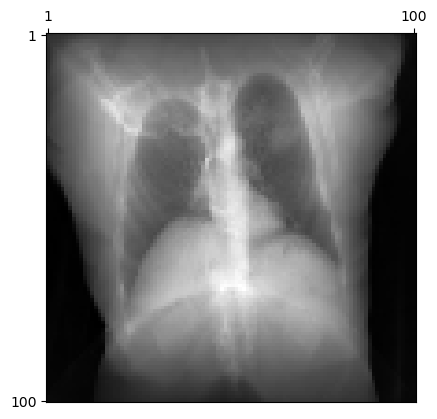

In [8]:
for _ in tqdm(range(100)):
    def closure(drr=drr, ground_truth=ground_truth):
        optimizer.zero_grad()
        estimate = drr()
        loss = -criterion(ground_truth, estimate)
        loss.backward(retain_graph=True)
        if loss < -0.999:
            raise StopIteration
        return loss
    
    try:
        optimizer.step(closure)
    except StopIteration:
        break

plot_drr(drr())

In [9]:
drr

Parameter containing:
tensor([200.], device='cuda:0')
Parameter containing:
tensor([[3.1519, 0.0062, 1.5666]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[179.4312, 179.7244, 166.4834]], device='cuda:0', requires_grad=True)

In [10]:
-criterion(ground_truth, drr())

tensor([-0.9992], device='cuda:0', grad_fn=<NegBackward0>)